In [1]:
import sys
sys.path.append('..')

In [2]:
from lariat import Event

In [21]:
import cv2
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from skimage.morphology import binary_closing, remove_small_objects, square, binary_dilation, medial_axis, thin, skeletonize
from sklearn.linear_model import RANSACRegressor

In [5]:
deuterons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/deuteron_candidates_bbox_t100.csv') # from within vertices bounding box
protons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/protons_one_track_filepaths.csv') # with only one track from reco

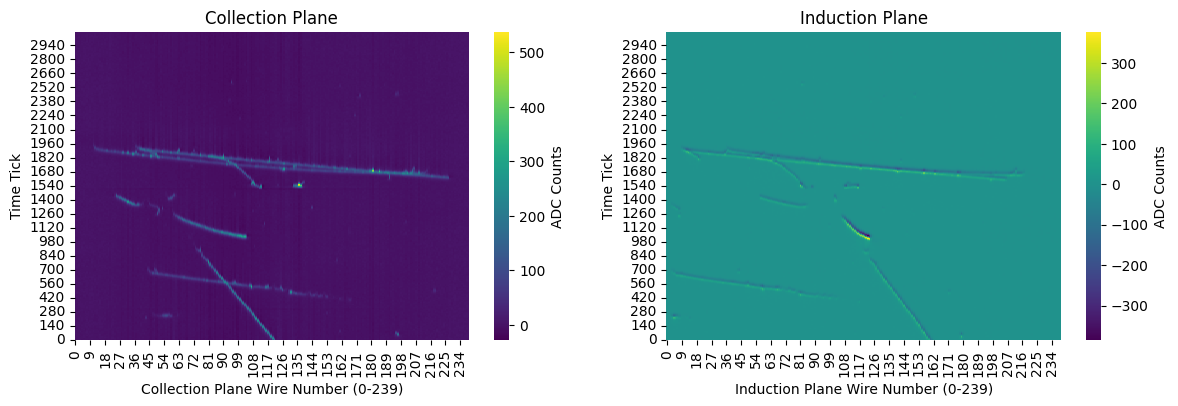

In [6]:
n = 200
event = Event(deuterons.iloc[n]['file_path'], index=deuterons.iloc[n]['event_index'])

In [179]:
induction = event.induction
collection = event.collection

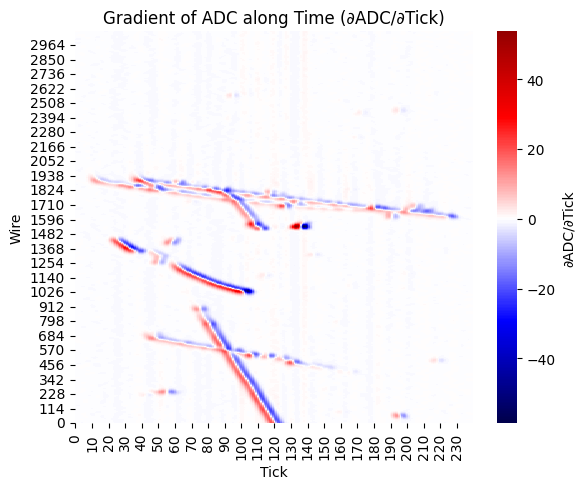

In [183]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Step 1: (Optional) smooth along time axis
adc_smooth = gaussian_filter(collection, sigma=(2, 2))  # blur only along time (y)

# Step 2: compute gradient w.r.t. time (axis=0)
grad_y = np.gradient(adc_smooth, axis=0)

# Step 3: plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(grad_y.T, cmap='seismic', center=0, cbar_kws={'label': '∂ADC/∂Tick'})

plt.title("Gradient of ADC along Time (∂ADC/∂Tick)")
plt.xlabel("Tick")
plt.ylabel("Wire")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [416]:
plane = collection

In [417]:
from scipy.ndimage import maximum_filter, gaussian_filter
import numpy as np

# 1. Apply a max filter in 2D
neighbourhood = (1, 7) # size of window to look for maxima
local_max = (plane == maximum_filter(plane, size=neighbourhood))

# 2. Suppress low values (optional threshold)
threshold = np.percentile(plane, 99) * 0.55
peak_mask = (plane > threshold) & local_max


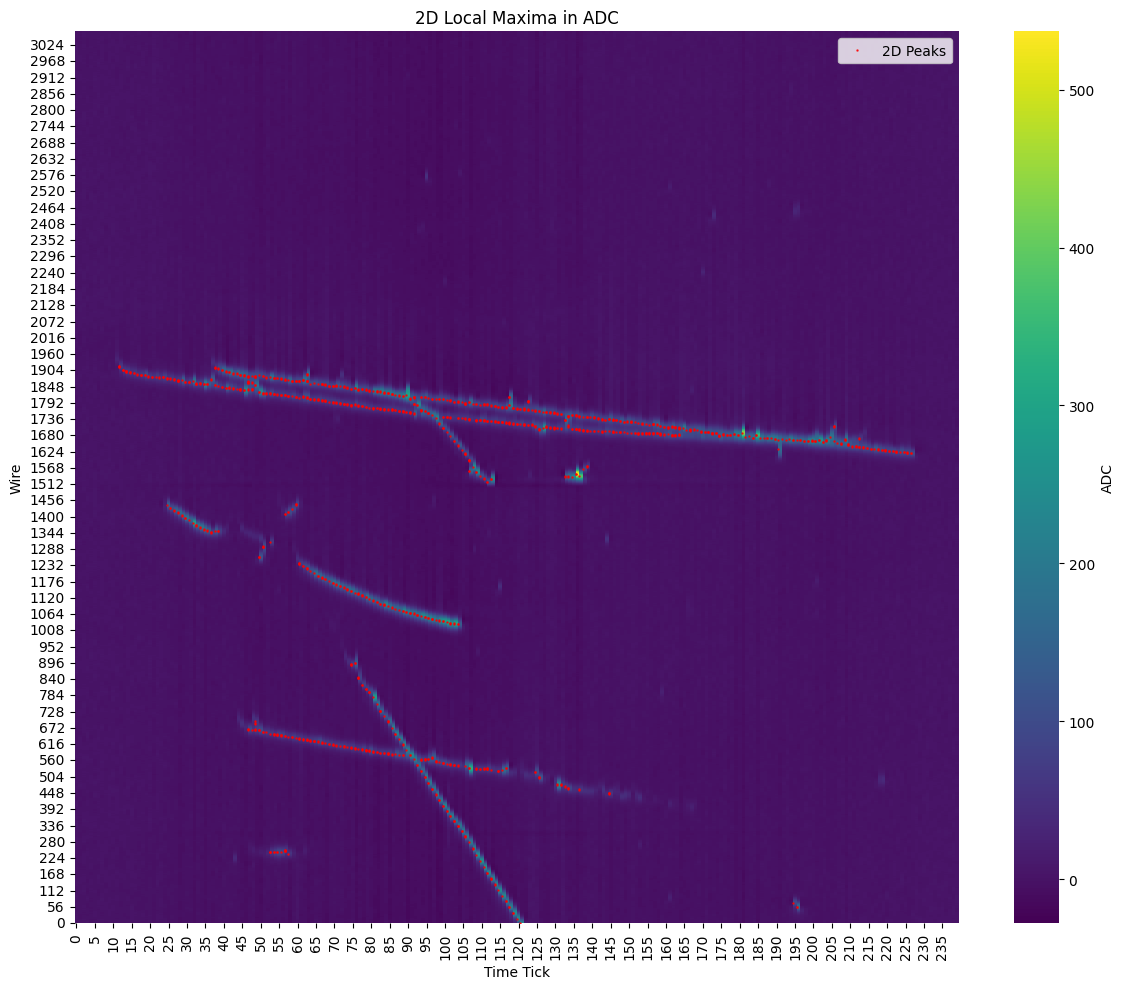

In [418]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(plane.T, cmap='viridis', cbar_kws={'label': 'ADC'})
ys, xs = np.where(peak_mask)  # (wire, tick)
plt.plot(ys, xs, 'r.', markersize=1.5, alpha=0.8, label='2D Peaks')
plt.xlabel("Time Tick")
plt.ylabel("Wire")
plt.gca().invert_yaxis()
plt.title("2D Local Maxima in ADC")
plt.legend()
#plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [419]:
ys, xs = np.nonzero(peak_mask)
points = np.column_stack((ys, xs))

In [420]:
from scipy.spatial import cKDTree
import networkx as nx
import numpy as np

tree = cKDTree(points)
pairs = tree.query_pairs(r=7)  # r = proximity threshold

G = nx.Graph()
for (y, x) in points:
    G.add_node((y, x))

for i, j in pairs:
    p1 = tuple(points[i])
    p2 = tuple(points[j])
    dy, dx = p2[0] - p1[0], p2[1] - p1[1]
    dist = np.hypot(dy, dx)
    G.add_edge(p1, p2, weight=dist)  # No angle, only Euclidean

G.remove_nodes_from([n for n, d in G.degree if d == 0])


In [421]:
import numpy as np
import networkx as nx

# Assume: `points` is an (N, 2) numpy array of (y, x) = (tick, wire) coordinates of peak points
points = np.column_stack(np.nonzero(peak_mask))  # or however you've defined your peaks
point_set = set(map(tuple, points))  # for fast lookup

# Build the graph
G = nx.Graph()
R = 25  # radius in pixels

for y, x in points:
    G.add_node((y, x))  # add all nodes first

    # Loop over neighbours in a square window
    for dy in range(-R, R + 1):
        for dx in range(-R, R + 1):
            if dy == 0 and dx == 0:
                continue

            ny, nx = y + dy, x + dx
            if (ny, nx) not in point_set:
                continue

            dist = np.hypot(dy, dx)
            if dist <= R:
                G.add_edge((y, x), (ny, nx), weight=dist)


In [422]:
print(f"{G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

1343 nodes, 39336 edges


In [423]:
import math
import networkx as nx

angle_threshold = math.radians(60)  # 60° in radians
labels   = -np.ones_like(plane, int)
track_id = 0

for comp in nx.connected_components(G):
    if len(comp) < 5:
        continue

    # 2-A  sort peaks by time-tick to obtain a walk-order
    comp_sorted = sorted(comp, key=lambda p: p[0])  # sort by y (tick)

    prev_vec = None
    for idx, (y, x) in enumerate(comp_sorted):
        # start a new track after a big turn
        if idx == 0 or prev_vec is None:
            current_id = track_id
            track_id  += 1
        else:
            dy_prev, dx_prev = prev_vec
            if idx < len(comp_sorted) - 1:        # look-ahead vector
                dy_next = comp_sorted[idx+1][0] - y
                dx_next = comp_sorted[idx+1][1] - x
                # angle between successive steps
                dot   = dy_prev*dy_next + dx_prev*dx_next
                mag   = math.hypot(dy_prev, dx_prev) * math.hypot(dy_next, dx_next)
                if mag > 0:
                    turn = math.acos(np.clip(dot / mag, -1, 1))
                    if turn > angle_threshold:     # sharp change ⇒ new label
                        current_id = track_id
                        track_id  += 1
            prev_vec = (dy_next, dx_next)

        labels[y, x] = current_id


In [424]:
import networkx as nx
labels = -np.ones_like(plane, dtype=int)
track_id = 0
for comp in nx.connected_components(G):
    if len(comp) < 5:  # ignore tiny fragments
        continue
    for y, x in comp:
        labels[y, x] = track_id
    track_id += 1


In [426]:
tracks = []
for tid in range(labels.max() + 1):
    ys, xs = np.where(labels == tid)
    if len(xs) < 5:
        continue
    tracks.append(np.column_stack((ys, xs)))

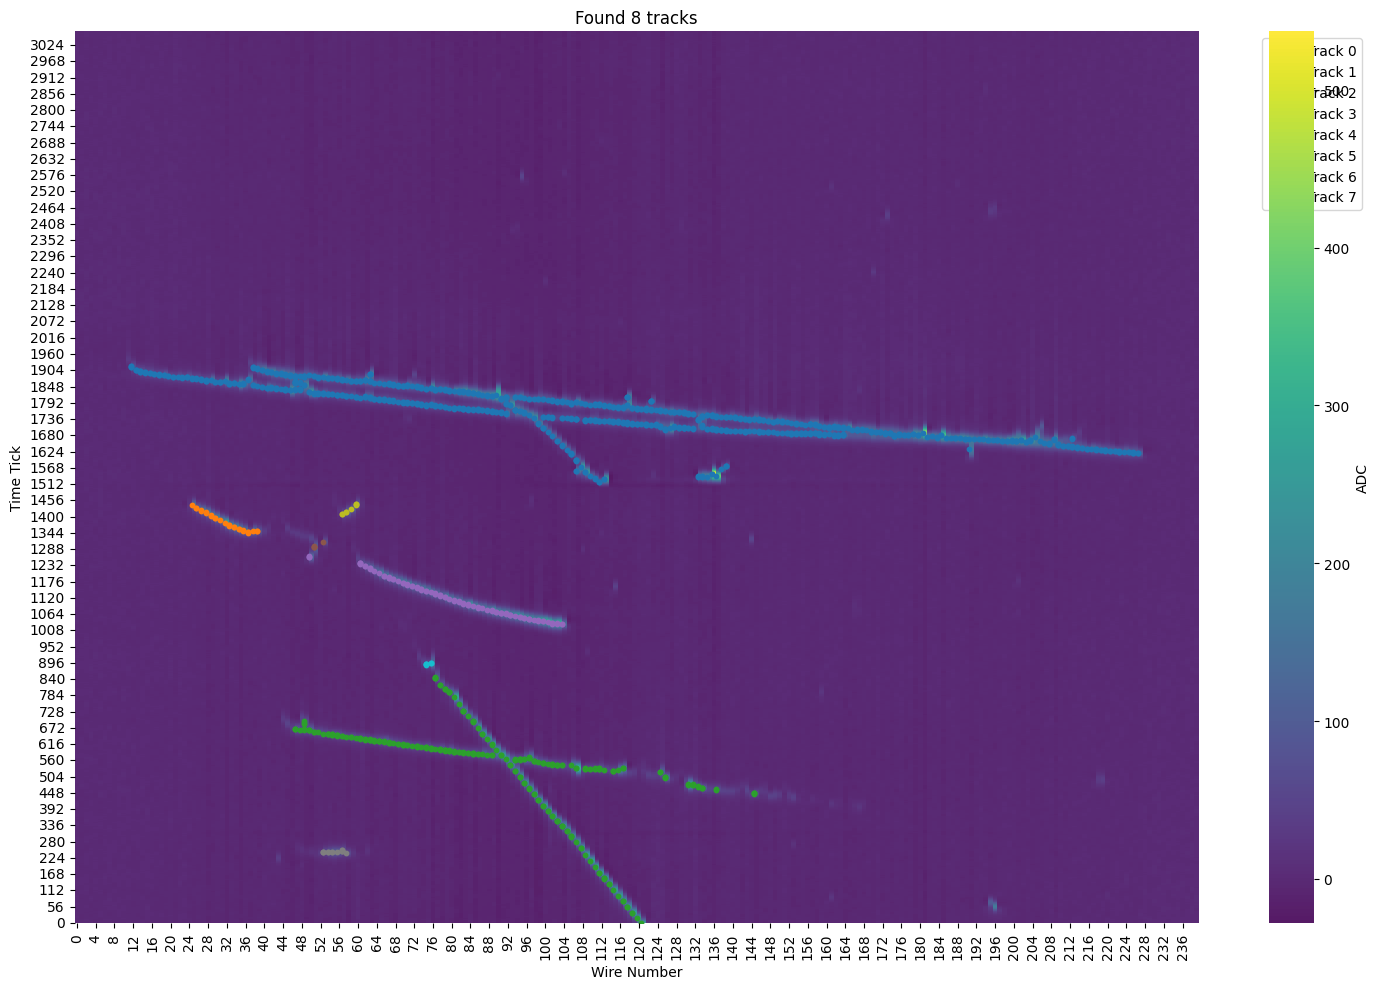

In [427]:
# Plot the tracks found
plt.figure(figsize=(15, 10))

# Plot the original  plane as background
sns.heatmap(plane.T, cmap='viridis', alpha=0.9, cbar_kws={'label': 'ADC'})

# Plot each track with a different color
colors = plt.cm.tab10(np.linspace(0, 1, len(tracks)))

for i, track in enumerate(tracks):
    ys, xs = track[:, 0], track[:, 1]
    plt.scatter(ys, xs, c=[colors[i]], s=10, alpha=1, label=f'Track {i}')

plt.xlabel("Wire Number")
plt.ylabel("Time Tick")
plt.title(f"Found {len(tracks)} tracks")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()